In [1]:
DATASET_NAME = "Deco"

DATA_DIR = "../data"
REFINED_PATH = f"{DATA_DIR}/{DATASET_NAME}/refined.json"

# Figure 2
An overview over the datasets

## Figure 2a - Multi-Table-Sheets

In [2]:
from os.path import join
import json


with open(REFINED_PATH) as f:
    refined_data = json.load(f)
    
table_count_frequencies = {}
for key, refined in refined_data.items():
    table_count = refined["table_count"]
    table_count_frequencies[table_count] = table_count_frequencies.get(table_count, []) + [key]

for table_count, sheet_names in table_count_frequencies.items():
    table_count_frequencies[table_count] = len(sheet_names)


In [3]:
data = {}
data[10] = 0

for key, value in table_count_frequencies.items():
    if key >= 10:
        data[10] += value
    elif key > 1:
        data[key] = value
    else:
        continue

sheets_with_more_than_10_tables = sum([v for k, v in table_count_frequencies.items() if k > 10])
avg_table_per_sheet = sum([k * v for k, v in table_count_frequencies.items()]) / len(refined_data.keys())

summary_text = "\n".join([
    f"#sheets 1 table = {table_count_frequencies[1]}",
    f"#sheets > 10 tables = {sheets_with_more_than_10_tables}",
    f"max #tables = {max(table_count_frequencies.keys())}",
    f"avg # tables = {avg_table_per_sheet}"
])

Text(0.9, 0.9, '#sheets 1 table = 493\n#sheets > 10 tables = 3\nmax #tables = 49\navg # tables = 1.5787781350482315')

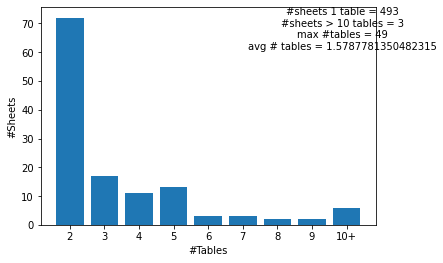

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = plt.subplot()

ax.set_xlabel("#Tables")
ax.set_ylabel("#Sheets")

ax.set_xticks(range(1, 11))
ax.set_xticklabels([str(i) for i in range(1, 10)] + ["10+"])

ax.bar(
    data.keys(),
    data.values(),
)

plt.text(0.9, 0.9,summary_text,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

_Only for Deco, as there a comparison to the paper is possible_


While the plot looks really similar, the number are different. This is simply because we filtered out some sheet because of their size or because they contained hidden columns or rows.

However, this difference in dataset can not be the reason for an __increase__ on `max #tables`.


Investigation follows in the next few cells of this section.

In [5]:

l = []

max_n_regions = 0
max_key = ""
for key, sheet_data in refined_data.items():
    l.append((key, sheet_data["table_count"]))
    if sheet_data["table_count"] > max_n_regions:
        max_n_regions = sheet_data["table_count"]
        max_key = key
print(f"The Key with the most tables is {max_key}!")
print(f"It has {max_n_regions} tables in the preprocessed annotations!")

annotation_path = join(DATA_DIR, DATASET_NAME, "annotations_elements.json")
with open(annotation_path) as f:
    annotation_data = json.load(f)

max_key_data = annotation_data[max_key]
tables = [region for region in max_key_data["regions"] if region["region_type"] == "Table"]
print(f"And {len(tables)} tables in the raw annotations!")


The Key with the most tables is jason_wolfe__13485__daily historical usage values.xlsx_Sheet1.csv!
It has 49 tables in the preprocessed annotations!
And 49 tables in the raw annotations!


In [6]:
sorted(l, key=lambda x: x[1], reverse=True)[:5]

[('jason_wolfe__13485__daily historical usage values.xlsx_Sheet1.csv', 49),
 ('mark_taylor__24725__ClickInTradingProducts.xlsx_DatabaseTABLES.csv', 17),
 ('juan_hernandez__17717__PJM_Cinergy Prices.xlsx_Sheet1.csv', 16),
 ('lindy_donoho__22013__RedRockAllocSumm.xlsx_Dec 4,2001.csv', 10),
 ('lynn_blair__24335__MS Directory by Teams.xlsx_Sheet1.csv', 10)]

We find out that `jason_wolfe__13485__daily historical usage values.xlsx_Sheet1.csv` is the sheet with 49 tables, and is persumably missing from the authors dataset. The next biggest table count is in `mark_taylor__24725__ClickInTradingProducts.xlsx_DatabaseTABLES.csv` which is the only one with 17 tables, which matches the authors highest count!

Either our dataset contains more data, or the authors filtered out this sheet.

## Figure 2b - Edge Counts

In [7]:
edges = []
for key, value in refined_data.items():
    
    edges.append({
        "edge_count": value["edge_count"],
        "is_multi_table": value["table_count"] > 1,
    })
    
single_table = [t["edge_count"] for t in edges if not t["is_multi_table"]]
multi_table = [t["edge_count"] for t in edges if t["is_multi_table"]]

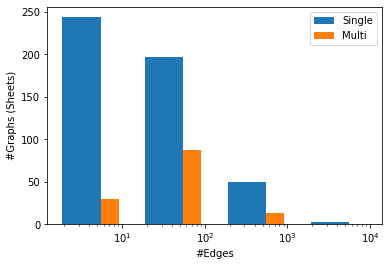

In [8]:
fig = plt.figure()

ax = plt.subplot()

plt.xscale('log')
ax.set_xlabel("#Edges")
ax.set_ylabel("#Graphs (Sheets)")
ax.hist([single_table, multi_table], bins=[10**i for i in range(5)], label=["Single", "Multi"])
ax.legend()

## Figure 2c - Horizontal Gaps

In [9]:
between = []
inside = []
for key, value in refined_data.items():
    if "jason_wolfe__13485__daily historical usage values.xlsx_Sheet1.csv" == key:
        continue
    if value["edge_count"] > 100:
        between.extend(value["xs_between_widths"])
        inside.extend(value["xs_inside_widths"])

# Omit outliers
between = [x for x in between if x < 80]
inside = [x for x in inside if x < 80]

{'whiskers': [<matplotlib.lines.Line2D at 0x7eff505125e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7eff50512f70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7eff50485df0>,
 'medians': [<matplotlib.lines.Line2D at 0x7eff50512b20>,
 'fliers': [<matplotlib.lines.Line2D at 0x7eff50446280>,
 'means': []}

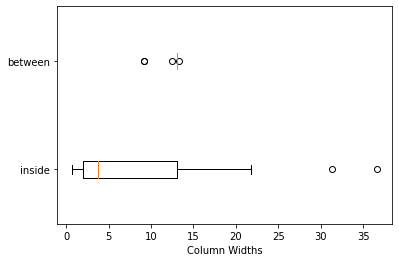

In [10]:
fig = plt.figure()

ax = plt.subplot()

ax.set_xlabel("Column Widths")
plt.boxplot([inside, between], vert=False, labels=["inside", "between"])